In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
IMAGE_SHAPE=(224,224)

In [3]:
import pathlib
data_dir=pathlib.Path("/home/sanjana/Desktop/medical_imaging/cervical-cancer")
data_dir

PosixPath('/home/sanjana/Desktop/medical_imaging/cervical-cancer')

In [4]:
image_count=len(list(data_dir.glob('*/*jpg')))
image_count

962

In [5]:
lesions_dict={
    'NILM': list(data_dir.glob('NILM/*')),
    'LSIL': list(data_dir.glob('LSIL/*')),
    'HSIL': list(data_dir.glob('HSIL/*')),
    'SCC': list(data_dir.glob('SCC/*')),
}

In [6]:
lesions_labels={
    'NILM': 0,
    'LSIL': 1,
    'HSIL': 2,
    'SCC': 3,
}

In [7]:
x, y=[],[]
for lesions_name, images in lesions_dict.items():
    for image in images:
        img=cv2.imread(str(image))
        x.append(img)
        y.append(lesions_labels[lesions_name])

In [8]:
x=np.array(x)
y=np.array(y)

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [10]:
x_train_scaled=x_train/255
x_test_scaled=x_test/255
x_val_scaled=x_val/255
print(len(x_train_scaled))
print(len(x_val_scaled))
print(len(x_test_scaled))

576
193
193


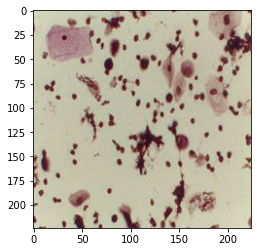

In [12]:
plt.imshow(x[575])

In [13]:
data_aug=keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(224,224,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

In [14]:
from tensorflow.keras.applications import EfficientNetB0

num_lesions=4

efficient_net = EfficientNetB0(
    weights='imagenet',
    input_shape=(224,224,3),
    include_top=False,
    pooling='max'
)

model=tf.keras.Sequential([
    data_aug,
    efficient_net, 
    #tf.keras.layers.Dense(512, activation="relu"),
    #tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(num_lesions)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 1280)              4049571   
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 4,054,695
Trainable params: 4,012,672
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
import matplotlib.pyplot as plt

model.compile(
    optimizer="adam", 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc'])

history = model.fit(x_train_scaled, y_train, validation_data=(x_val_scaled, y_val), batch_size=20,epochs=5)
print(history.history.keys())


Epoch 1/5
29/29 [==============================] - 221s 7s/step - loss: 1.2406 - acc: 0.8160 - val_loss: 2.1895 - val_acc: 0.2073
Epoch 2/5
29/29 [==============================] - 96s 3s/step - loss: 0.4520 - acc: 0.8819 - val_loss: 3.1610 - val_acc: 0.2073
Epoch 3/5
29/29 [==============================] - 181s 6s/step - loss: 0.2690 - acc: 0.9097 - val_loss: 1.6702 - val_acc: 0.2073
Epoch 4/5
20/29 [===================>..........] - ETA: 41s - loss: 0.1282 - acc: 0.9450

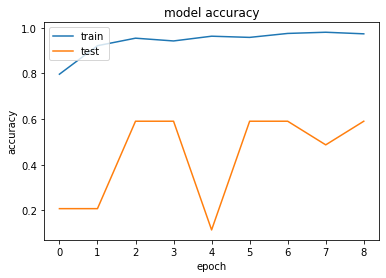

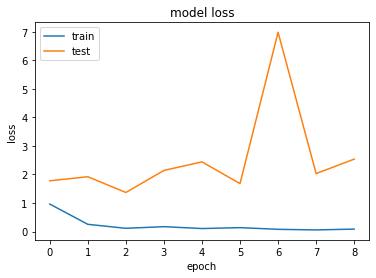

In [17]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
model.evaluate(x_test_scaled, y_test)

7/7 [==============================] - 5s 748ms/step - loss: 2.1175 - acc: 0.6632


[2.1175198554992676, 0.6632124185562134]

In [35]:
len(x_train_scaled)

721